In [26]:
#Carrega bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind, mannwhitneyu, shapiro, levene, kruskal

In [ ]:
#Cria função para comparar dois grupos
def comparar_grupos_visual(df, grupo_col, valor_col, grupo1, grupo2):
    # Separar os grupos
    g1 = df[df[grupo_col] == grupo1][valor_col]
    g2 = df[df[grupo_col] == grupo2][valor_col]

    # Estatísticas descritivas
    media1, media2 = g1.mean(), g2.mean()
    mediana1, mediana2 = g1.median(), g2.median()
    var1, var2 = g1.var(), g2.var()

    # Testes
    p_norm1 = shapiro(g1)[1]
    p_norm2 = shapiro(g2)[1]
    p_levene = levene(g1, g2)[1]

    if p_norm1 > 0.05 and p_norm2 > 0.05:
        p_test = ttest_ind(g1, g2, equal_var=(p_levene > 0.05))[1]
        teste = "Teste t de Student"
    else:
        p_test = mannwhitneyu(g1, g2, alternative='two-sided')[1]
        teste = "Teste de Mann-Whitney"

    # Visualização
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df[df[grupo_col].isin([grupo1, grupo2])],
            x=grupo_col, y=valor_col, hue=grupo_col, palette='Set2', legend=False)
    plt.title(f'{valor_col} por {grupo_col}')
    plt.xlabel(grupo_col)
    plt.ylabel(valor_col)

    # Texto explicativo
    plt.figtext(0.5, -0.05,
        f"Média: {grupo1} = {media1:.2f}, {grupo2} = {media2:.2f} | "
        f"Mediana: {mediana1:.2f} vs {mediana2:.2f} | "
        f"Variância: {var1:.2f} vs {var2:.2f}\n"
        f"{teste} → p-valor = {p_test:.4f} → "
        f"{'Diferença significativa ✔' if p_test < 0.05 else '❌ Sem diferença significativa'}",
        ha='center', fontsize=10)
    plt.tight_layout()
    

A função tem como objetivo comparar se duas variáveis sendo uma numérica e outra categórica, iniciando com suas estatisticas descritivas(média, mediana e variância), depois testando se seguem uma distribuição normal(shapiro), se suas variâncias são iguais(levele) e por fim aplica teste de hipótese. Se forem normais utiliza no teste o teste t de Student senão usa Mann-Whitneyu(não  paramétrico) para responder se foi acaso ou não a diferença observada.

In [14]:
#Carrega dataset
insurance = pd.read_csv('insurance.csv')

In [15]:
# Primeiras linhas do dataset
insurance.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [16]:
#Verificaremos se tem algum valor nulo entre as variáveis
insurance.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [17]:
# Vamos entender o que cada coluna representa e se há necessidade de alguma transformação
insurance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [18]:
insurance.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


Como vimos não tem nenhum valor nulo e temos 1338 linhas em nossa amostra. Além disso, temos algumas informações sobre as variáveis numéricas. Vamos aprofundar um pouco como age, bmi e children se relacionam com charges, visto que nosso foco é o entendimento destas cobranças.Porém, antes iremos analisar como esta a distribuição de charges.

In [38]:
# Análise inicial da variável target
insurance['charges'].describe()

count     1338.000000
mean     13270.422265
std      12110.011237
min       1121.873900
25%       4740.287150
50%       9382.033000
75%      16639.912515
max      63770.428010
Name: charges, dtype: float64

A diferença entre média e media mostra que o gráfico tem assimetria para a direita, poucos pacientes com custos mais elevados(>50%).

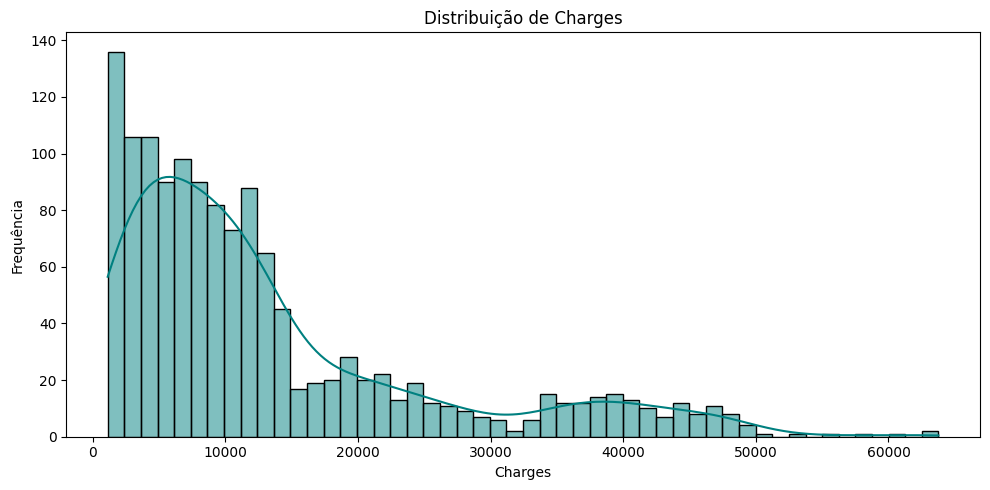

In [39]:
# Distribuição de charges
plt.figure(figsize=(10, 5))
sns.histplot(insurance['charges'], bins=50, kde=True, color='teal')
plt.title('Distribuição de Charges')
plt.xlabel('Charges')
plt.ylabel('Frequência')
plt.tight_layout()
plt.show()


Conforme identificamos ele tem uma cauda longa a direita, nos levando a crer que exista outliers positivos. Vamos entender usando o boxplot esses possíveis outliers e analisaremos a partir da distancia interquatilica e seu limite superior(1,5 X distancia) se realmente seriam outliers

In [40]:
q3 = insurance['charges'].quantile(0.75)
iqr = insurance['charges'].quantile(0.75) - insurance['charges'].quantile(0.25)
limite_superior = q3 + 1.5 * iqr

outliers = insurance[insurance['charges'] > limite_superior]
outliers.sort_values('charges', ascending=False).head()


,age,sex,bmi,children,smoker,region,charges,age_group
543,54,female,47.410,0,yes,southeast,63770.42801,51-60
1300,45,male,30.360,0,yes,southeast,62592.87309,41-50
1230,52,male,34.485,3,yes,northwest,60021.39897,51-60
577,31,female,38.095,1,yes,northeast,58571.07448,31-40
819,33,female,35.530,0,yes,northwest,55135.40209,31-40


A amostra acima demonstra os possíveis outliers. Vamos colocar uma flag de top 5% para marcar os mais caros e visualizar se tem um perfil

In [41]:
# Definir o limiar de top 5%
threshold = insurance['charges'].quantile(0.95)

# Criar flag binária
insurance['high_cost_flag'] = (insurance['charges'] >= threshold).astype(int)

# Verificar distribuição
print(f'Limiar do top 5%: R${threshold:,.2f}')
print(insurance['high_cost_flag'].value_counts())


Limiar do top 5%: R$41,181.83
high_cost_flag
0    1271
1      67
Name: count, dtype: int64


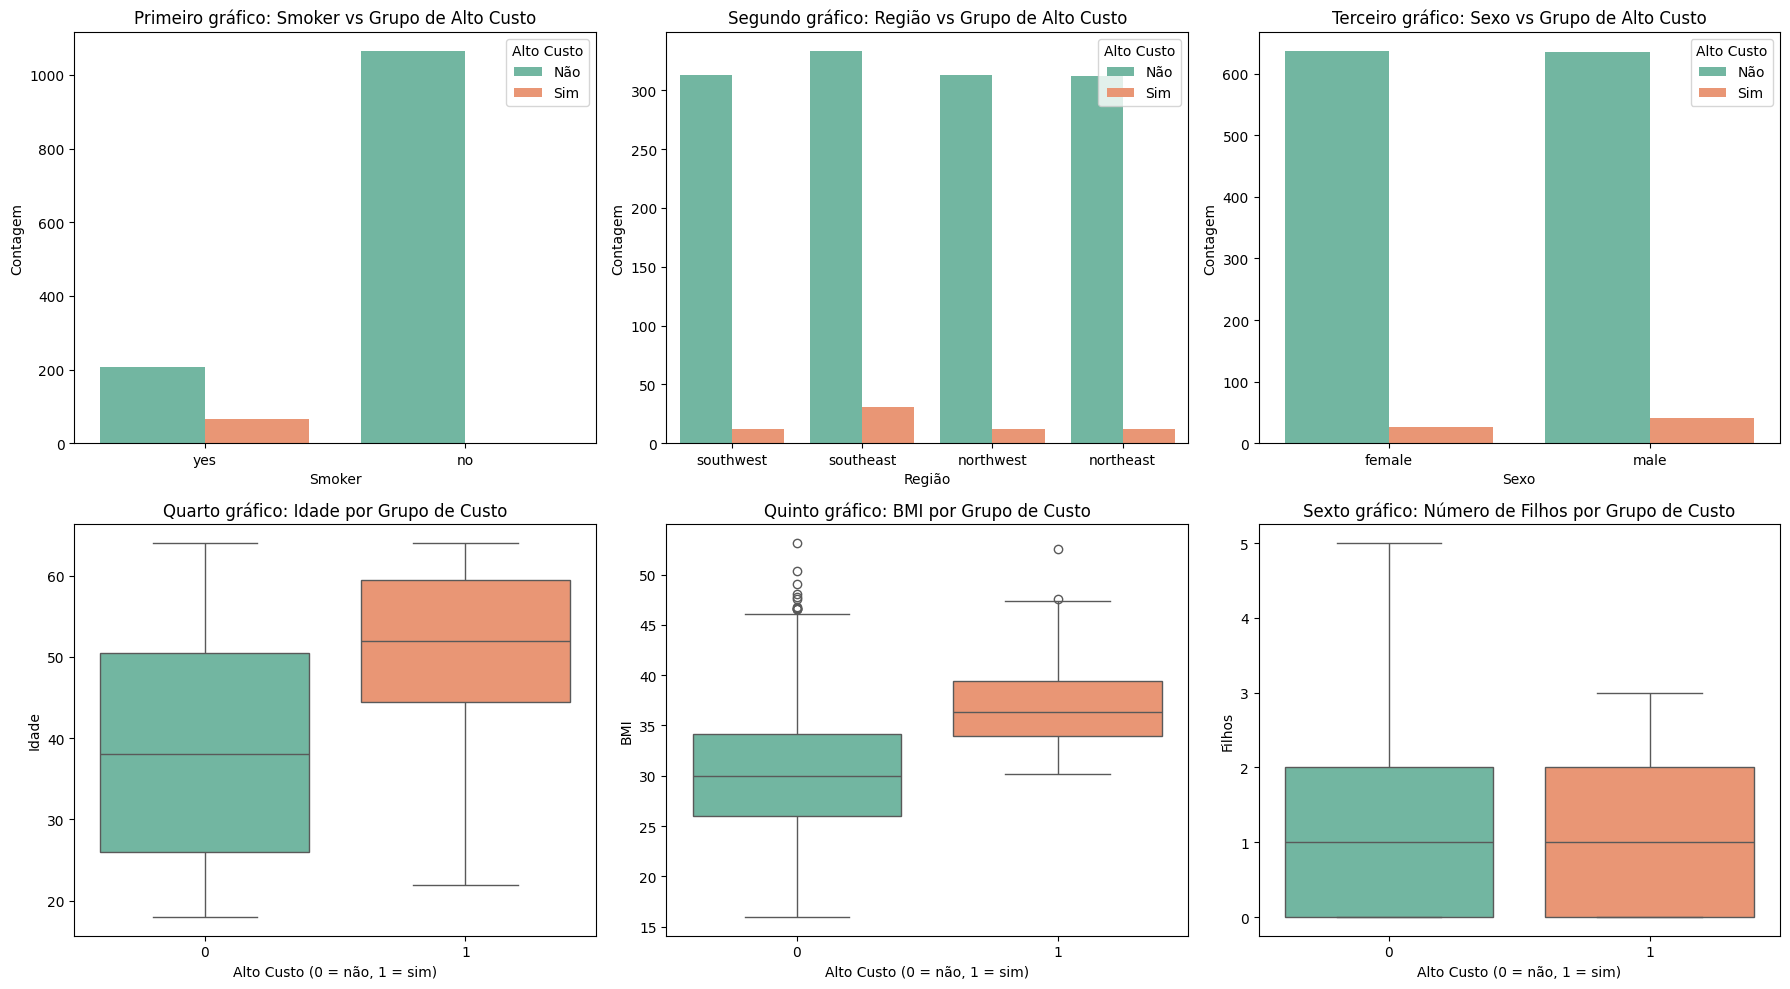

In [43]:
fig, ax = plt.subplots(2, 3, figsize=(18, 10))
cor = 'teal'

# 🔹 CATEGÓRICAS

# Primeiro gráfico: Smoker vs High Cost
sns.countplot(data=insurance, x='smoker', hue='high_cost_flag', ax=ax[0,0], palette='Set2')
ax[0,0].set_title('Primeiro gráfico: Smoker vs Grupo de Alto Custo')
ax[0,0].set_xlabel('Smoker')
ax[0,0].set_ylabel('Contagem')
ax[0,0].legend(title='Alto Custo', labels=['Não', 'Sim'])

# Segundo gráfico: Region vs High Cost
sns.countplot(data=insurance, x='region', hue='high_cost_flag', ax=ax[0,1], palette='Set2')
ax[0,1].set_title('Segundo gráfico: Região vs Grupo de Alto Custo')
ax[0,1].set_xlabel('Região')
ax[0,1].set_ylabel('Contagem')
ax[0,1].legend(title='Alto Custo', labels=['Não', 'Sim'])

# Terceiro gráfico: Sex vs High Cost
sns.countplot(data=insurance, x='sex', hue='high_cost_flag', ax=ax[0,2], palette='Set2')
ax[0,2].set_title('Terceiro gráfico: Sexo vs Grupo de Alto Custo')
ax[0,2].set_xlabel('Sexo')
ax[0,2].set_ylabel('Contagem')
ax[0,2].legend(title='Alto Custo', labels=['Não', 'Sim'])

# 🔹 NUMÉRICAS

# Quarto gráfico: Idade por Grupo de Custo
sns.boxplot(data=insurance, x='high_cost_flag', y='age', hue='high_cost_flag', ax=ax[1,0], palette='Set2', legend=False)
ax[1,0].set_title('Quarto gráfico: Idade por Grupo de Custo')
ax[1,0].set_xlabel('Alto Custo (0 = não, 1 = sim)')
ax[1,0].set_ylabel('Idade')

# Quinto gráfico: BMI por Grupo de Custo
sns.boxplot(data=insurance, x='high_cost_flag', y='bmi', hue='high_cost_flag', ax=ax[1,1], palette='Set2', legend=False)
ax[1,1].set_title('Quinto gráfico: BMI por Grupo de Custo')
ax[1,1].set_xlabel('Alto Custo (0 = não, 1 = sim)')
ax[1,1].set_ylabel('BMI')

# Sexto gráfico: Número de Filhos por Grupo de Custo
sns.boxplot(data=insurance, x='high_cost_flag', y='children', hue='high_cost_flag', ax=ax[1,2], palette='Set2', legend=False)
ax[1,2].set_title('Sexto gráfico: Número de Filhos por Grupo de Custo')
ax[1,2].set_xlabel('Alto Custo (0 = não, 1 = sim)')
ax[1,2].set_ylabel('Filhos')

plt.tight_layout()
plt.show()

Analise Completa: O grupo de alto custo representa os 5% de pacientes com os maiores valores de cobrança no plano de saúde, acima de R$48.000. Esses indivíduos distorcem a distribuição de charges, que é fortemente assimétrica: enquanto a maioria paga menos de R$20.000, esse pequeno grupo concentra uma parcela significativa dos gastos totais. Ao analisar o perfil desses pacientes, nota-se que são majoritariamente fumantes, com BMI elevado e idade acima de 40 anos. Esses fatores combinados explicam a presença de outliers na cauda da distribuição e indicam que o risco financeiro está concentrado em um segmento bem definido. Identificar esse grupo é essencial para estratégias de precificação, prevenção e modelagem preditiva. Vamos agora aprofundar o entendimento deste dataset e tentar tirar mais insights a partir da abertura de cada uma das variáveis. Começaremos com as variáveis numéricas.

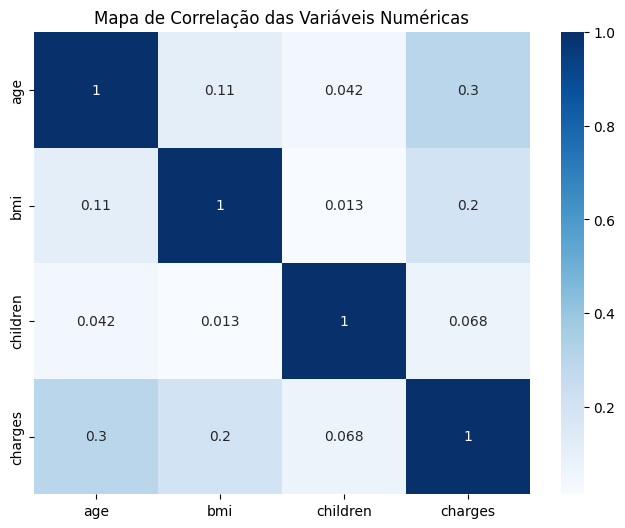

In [19]:
# Análise de correlação entre variáveis numéricas
plt.figure(figsize=(8, 6))
corr = insurance[['age', 'bmi', 'children', 'charges']].corr()
sns.heatmap(corr, annot=True, cmap='Blues')
plt.title('Mapa de Correlação das Variáveis Numéricas')
plt.savefig('images/correlation_heatmap.png')
plt.show()

Podemos identificar pela coluna de charges que todas as variáveis numéricas se relacionam positivamente com charges, porém são relações fracas. Mais a frente, teremos que entender como as variáveis categóricas impactam charges.

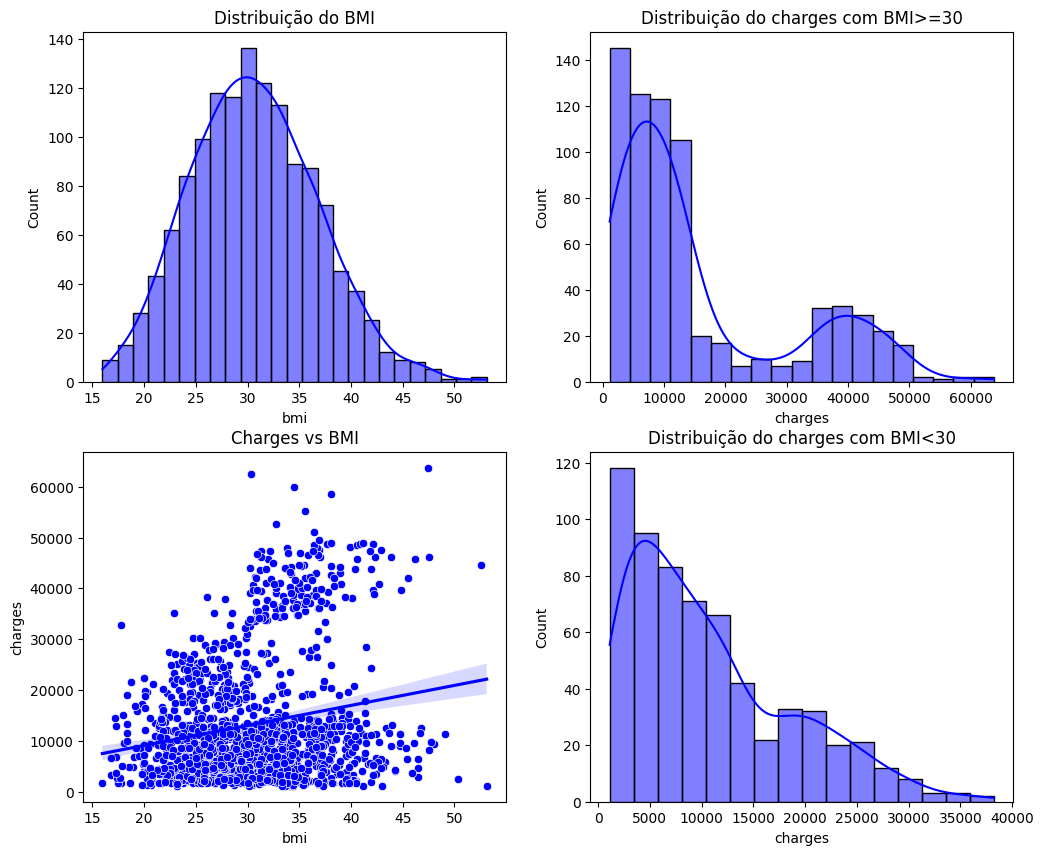

In [ ]:
# local e configuracao do plot
fig, ax = plt.subplots(2, 2, figsize=(12, 10))
# Primeiro gráfico é a distribuição do BMI
sns.histplot(insurance['bmi'], ax=ax[0,0], color='b', kde=True)
ax[0,0].set_title('Distribuição do BMI')
# Segundo gráfico é a distribuição da cobrança pelo bmi>=30
sns.histplot(insurance.query("bmi>=30")['charges'], ax=ax[0,1], color='b', kde=True)
ax[0,1].set_title('Distribuição do charges com BMI>=30')
#Terceiro gráfico é a dispersão entre cobrança e bmi
sns.scatterplot(x='bmi', y='charges', data=insurance, ax=ax[1,0], color='b')
sns.regplot(x='bmi', y='charges', data=insurance, ax=ax[1,0], scatter=False, color='b')
ax[1,0].set_title('Charges vs BMI')
# Quarto gráfico é a distribuição da cobrança pelo bmi<30
sns.histplot(insurance.query("bmi<30")['charges'], ax=ax[1,1], color='b', kde=True)
ax[1,1].set_title('Distribuição do charges com BMI<30')


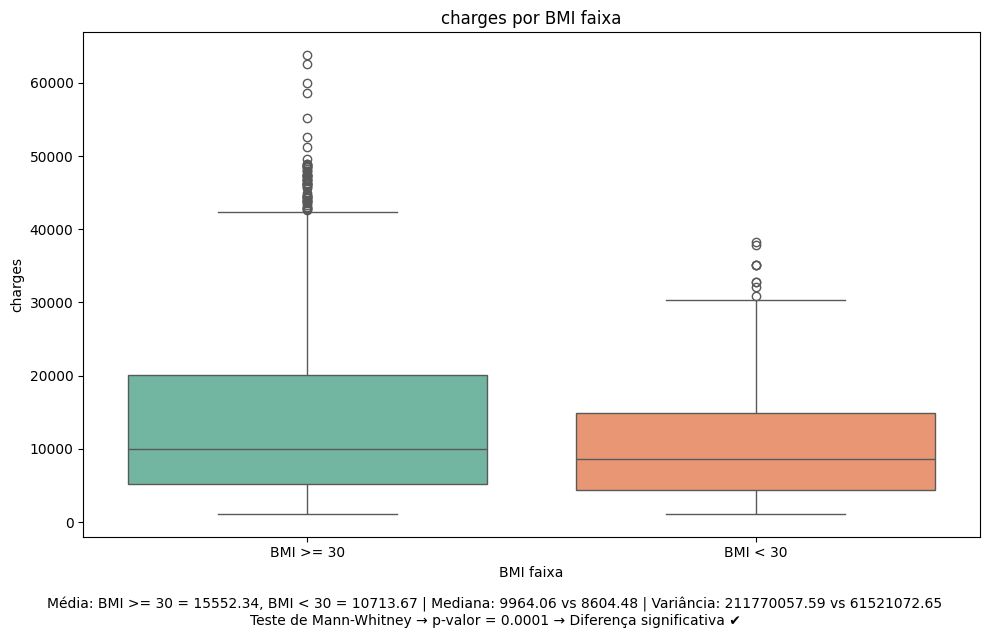

In [ ]:
#Investigação detalhada da relação entre BMI e Charges
charges_bmi = pd.DataFrame({
    'charges': pd.concat([
        insurance.query("bmi >= 30")['charges'],
        insurance.query("bmi < 30")['charges']
    ], ignore_index=True),
    'BMI faixa': ['BMI >= 30'] * len(insurance.query("bmi >= 30")) +
                 ['BMI < 30'] * len(insurance.query("bmi < 30"))
})

comparar_grupos_visual(charges_bmi, 'BMI faixa', 'charges', 'BMI >= 30', 'BMI < 30')


Análise completa BMI: Ao explorar os dados, identificamos uma diferença marcante entre os grupos de pacientes com BMI ≥ 30 e BMI < 30. O grupo com BMI mais elevado apresenta valores de cobrança significativamente maiores, evidenciado tanto pela média (sensível a outliers) quanto pela mediana (mais robusta e representativa do centro da distribuição). Esse contraste inicial nos leva a investigar a dispersão dos dados — e de fato, observamos uma variabilidade considerável dentro de cada grupo.

Além disso, os testes de normalidade indicam que os dados não seguem uma distribuição normal, o que nos direciona para o uso de testes não paramétricos. Aplicando o teste de Mann-Whitney, conseguimos confirmar que a diferença entre os grupos é estatisticamente significativa, ou seja, não é fruto do acaso.

Com esse resultado, temos respaldo para tratar os dois grupos de forma distinta e investigar estratégias específicas para entender os fatores que influenciam maiores cobranças. Isso abre espaço para análises mais direcionadas, como segmentações por perfil, comportamento ou risco, com o objetivo de extrair valor e gerar insights mais profundos sobre o padrão de cobrança entre os pacientes.

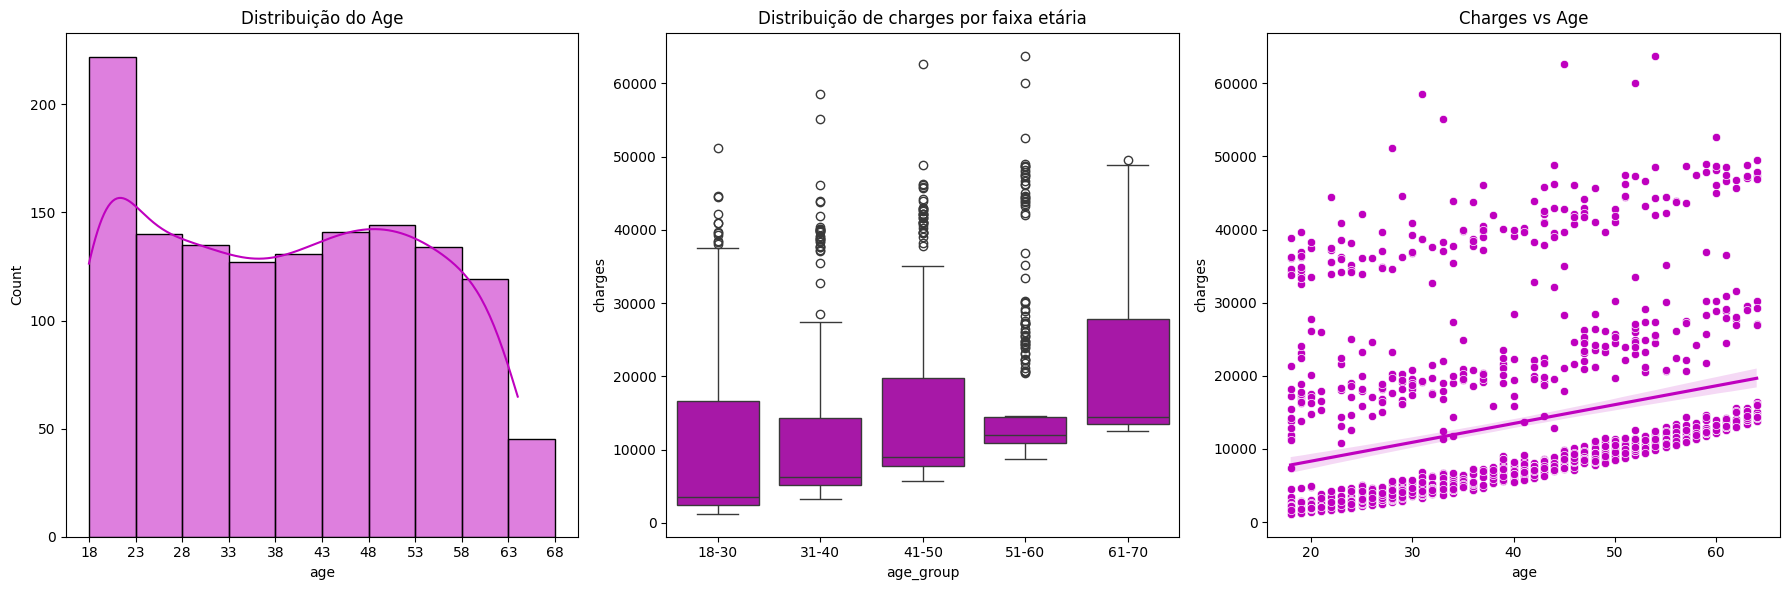

In [28]:
# local e configuracao do plot
fig, ax = plt.subplots(1, 3, figsize=(18, 6))

# Primeiro gráfico: distribuição do Age
bins = range(insurance['age'].min(), insurance['age'].max() + 5, 5)
sns.histplot(insurance['age'], ax=ax[0], color='m', kde=True, bins=bins)
ax[0].set_title('Distribuição do Age')
ax[0].set_xticks(list(bins))

# Segundo gráfico: distribuição de charges por faixa etária
bins = [18, 30, 40, 50, 60, 70]
labels = ['18-30', '31-40', '41-50', '51-60', '61-70']
insurance['age_group'] = pd.cut(insurance['age'], bins=bins, labels=labels)
sns.boxplot(data=insurance, x='age_group', y='charges', ax=ax[1], color='m')
ax[1].set_title('Distribuição de charges por faixa etária')

# Terceiro gráfico: dispersão entre age e charges
sns.scatterplot(x='age', y='charges', data=insurance, ax=ax[2], color='m')
sns.regplot(x='age', y='charges', data=insurance, ax=ax[2], scatter=False, color='m')
ax[2].set_title('Charges vs Age')

plt.tight_layout()



In [ ]:
insurance.age.corr(insurance.charges)

np.float64(0.29900819333064776)

In [29]:
#Validar se as médias de cobrança entre as faixas etárias são estatisticamente diferentes
grupos = [insurance[insurance['age_group'] == g]['charges'] for g in labels]
stat, p = kruskal(*grupos)
print(f'Estatística: {stat:.2f}, p-valor: {p:.4f}')

Estatística: 330.57, p-valor: 0.0000


Análise Completa Idade: A maioria dos pacientes está entre 18 e 30 anos, mas os custos aumentam com a idade. Gráficos e correlação (r = 0.30) mostram que pessoas mais velhas tendem a ter despesas maiores. O teste de Kruskal-Wallis confirma diferença significativa entre faixas etárias, validando a idade como fator relevante para segmentação e precificação.

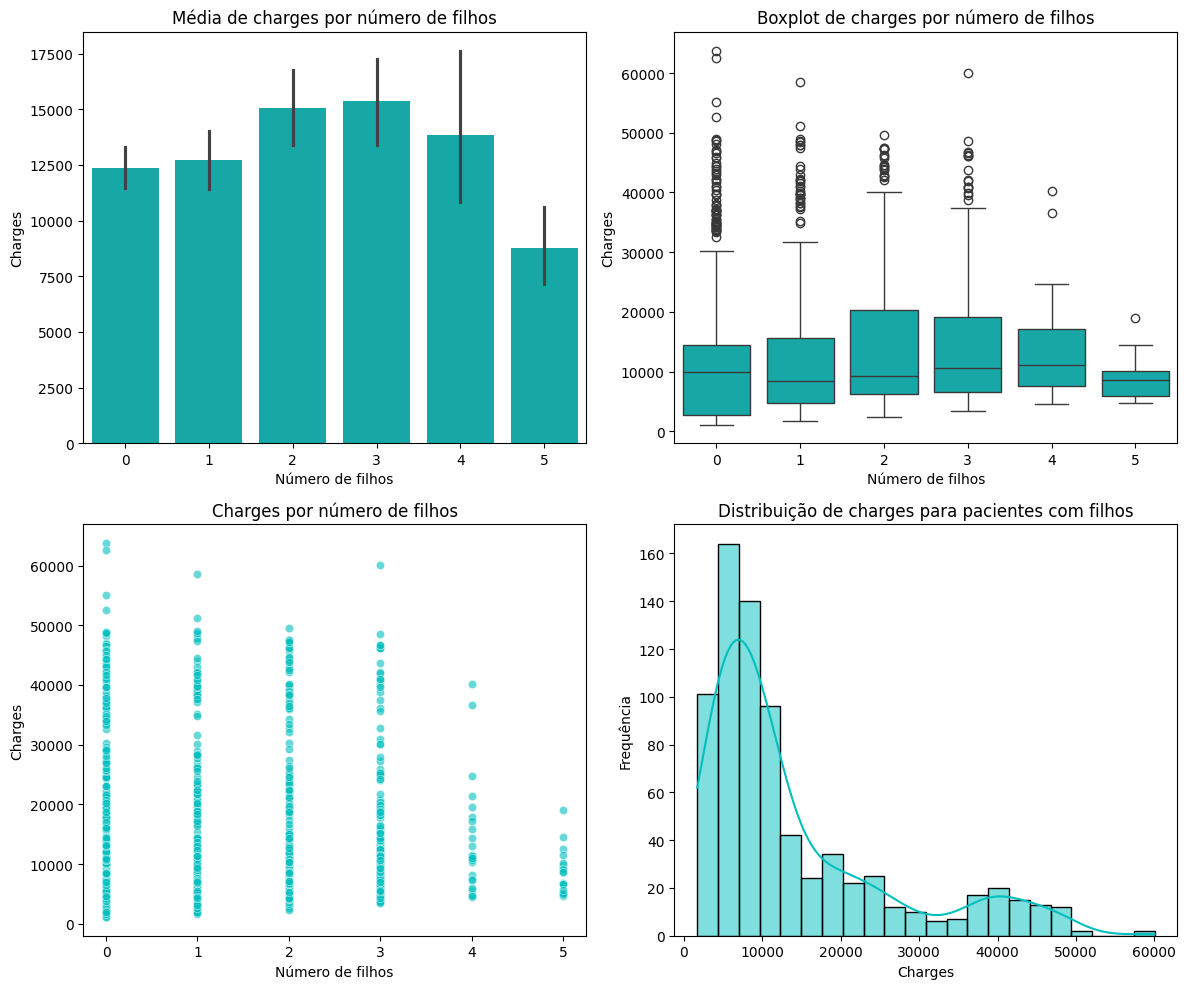

In [34]:
# Local e configuração do plot
fig, ax = plt.subplots(2, 2, figsize=(12, 10))

# Primeiro gráfico:Barras com média de charges por número de filhos
sns.barplot(data=insurance, x='children', y='charges', ax=ax[0,0], color='c', estimator='mean')
ax[0,0].set_title('Média de charges por número de filhos')
ax[0,0].set_xlabel('Número de filhos')
ax[0,0].set_ylabel('Charges')

# Segundo gráfico:Boxplot com distribuição de charges por número de filhos
sns.boxplot(data=insurance, x='children', y='charges', ax=ax[0,1], color='c')
ax[0,1].set_title('Boxplot de charges por número de filhos')
ax[0,1].set_xlabel('Número de filhos')
ax[0,1].set_ylabel('Charges')

#Terceiro gráfico:Scatterplot com linha de tendência da média
sns.scatterplot(x='children', y='charges', data=insurance, ax=ax[1,0], color='c', alpha=0.6)
ax[1,0].set_title('Charges por número de filhos')
ax[1,0].set_xlabel('Número de filhos')
ax[1,0].set_ylabel('Charges')


# Quarto gráfico: Histograma com distribuição de charges para quem tem filhos
sns.histplot(insurance.query("children > 0")['charges'], ax=ax[1,1], color='c', kde=True)
ax[1,1].set_title('Distribuição de charges para pacientes com filhos')
ax[1,1].set_xlabel('Charges')
ax[1,1].set_ylabel('Frequência')

plt.tight_layout()
plt.show()


In [35]:
#Teste estatístico para verificar se há diferença significativa nas médias de charges entre os diferentes números de filhos
grupos = [insurance[insurance['children'] == i]['charges'] for i in sorted(insurance['children'].unique())]
stat, p = kruskal(*grupos)
print(f'Estatística: {stat:.2f}, p-valor: {p:.4f}')


Estatística: 29.49, p-valor: 0.0000


Analise completa: O número de filhos não é um fator determinante para os custos de seguro. Embora haja variação nos valores, ela parece mais influenciada por outras variáveis, conforme já analisamos

Agora analisaremos as variáveis categóricas para entender se tabagismo, região e sexo são influentes para cobranças. Depois validaremos se o perfil identificado em charges consegue ser mais detalhado a pós a investigação em cada variável.

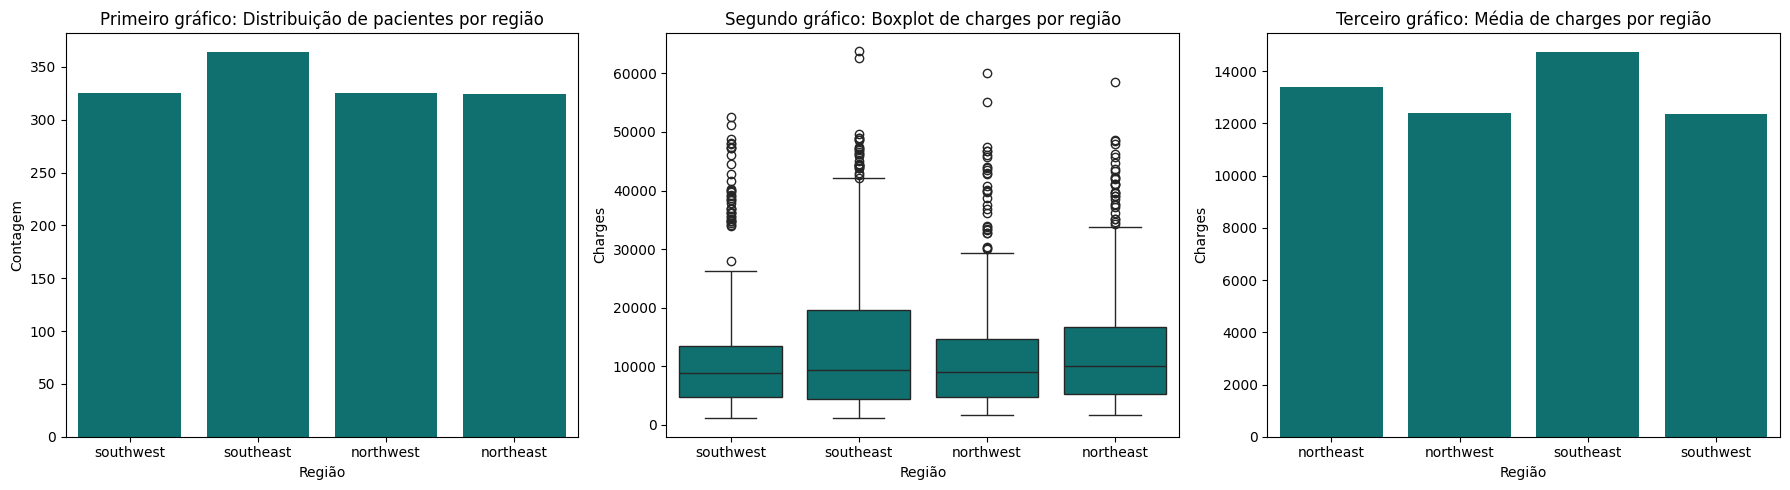

In [45]:
# Subplot com 3 gráficos
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

# Primeiro gráfico: distribuição de pacientes por região
sns.countplot(data=insurance, x='region', color='teal', ax=ax[0])
ax[0].set_title('Primeiro gráfico: Distribuição de pacientes por região')
ax[0].set_xlabel('Região')
ax[0].set_ylabel('Contagem')

# Segundo gráfico: boxplot de charges por região
sns.boxplot(data=insurance, x='region', y='charges', color='teal', ax=ax[1])
ax[1].set_title('Segundo gráfico: Boxplot de charges por região')
ax[1].set_xlabel('Região')
ax[1].set_ylabel('Charges')

# Terceiro gráfico: média de charges por região
mean_charges = insurance.groupby('region')['charges'].mean().reset_index()
sns.barplot(data=mean_charges, x='region', y='charges', color='teal', ax=ax[2])
ax[2].set_title('Terceiro gráfico: Média de charges por região')
ax[2].set_xlabel('Região')
ax[2].set_ylabel('Charges')

plt.tight_layout()
plt.show()